# Exploring Lending Club and Macroeconomic Data

This project involves evaluating the publically available portfolio data for unsecured personal loans originated by FinTech lender Lending Club. In the evaluation below, some basic aspects of the Lending Club data are explored, including loan sizes, loan volumes, and default rates over time. Some initial exploration of Lending Club's loan "grading" is also performed - higher letter-grade loans are expected to have higher charge-off probabilities. Next, the macroeconomic factors that might impact loan performance are evaluated to see how they have changed over time. Finally, an initial exploration of the relationship between macroeconomic factors and loan default rates is performed.

First, the libraries used to explore the data are imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The pre-merged data has been packaged as a Pandas dataframe in a .pkl file. That .pkl file is loaded into a dataframe 'df'.

The data file is too large to store in a Github repository, so it has been shared in the following Google Drive location (in .7z format):

https://drive.google.com/file/d/1RCgoJYONVQJek5zrlShaGEzjrk99rAIk/view?usp=sharing

In [2]:
data_directory = r'..\data'
df = pd.read_pickle(data_directory + r'\capstone_dataset.pkl')

# The loan terms contain whitespace characters. These need to be trimmed out.
df['term'] = df['term'].str.strip()

Loans that are still in repayment should not be included. An indicator is added for these loans which could still be in repayment. These are loans where the origination date plus the term of the loan has passed. One month is added as repayment does not begin in the first month. An additional three months for potential extensions due to hardships are added so that only completed terms are captured. The following functions are required for this to occur.

This functions below are required to perform a vector operation to add the requisite number of months, as described above, and were sourced from StackOverflow user unutbu.

In [3]:
def combine64(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def year(dates):
    "Return an array of the years given an array of datetime64s"
    return dates.astype('M8[Y]').astype('i8') + 1970

def month(dates):
    "Return an array of the months given an array of datetime64s"
    return dates.astype('M8[M]').astype('i8') % 12 + 1

def day(dates):
    "Return an array of the days of the month given an array of datetime64s"
    return (dates - dates.astype('M8[M]')) / np.timedelta64(1, 'D') + 1

The functions defined above are then used to create a boolean flag that is True if the loan has been through its entire course.

In [4]:
df['lag_time'] = df['term'].str[0:2].apply(int) + 4
start_date = df['date'].values
df['loan_end_date'] = combine64(year(start_date), months=month(start_date) + df['lag_time'], days=day(start_date))

# Create a column that is True if the max date in the data is before the end date
df['loan_ended_flag'] = df['loan_end_date'] < max(df['orig_month'])

An indicator is also required for whether or not the loan was charged off. Charged off loans have a loan status that is either 'Charge Off' or 'Does not meet the credit policy. Staus:Charged Off'

In [5]:
df['charge_off_flag'] = (df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')

One of the macroeconomic factors of interest is the S&P 500. This will be mesured as the change in the S&P 500 during the month in question. The dataset contains the beginning- and end-of-month S&P 500 values, so another column must be created containing the difference.

In [6]:
df['sp_500_diff'] = df['eom_value'] - df['bom_value']

In [9]:
trimmed_df = df.loc[df['loan_ended_flag']]

In [11]:
trimmed_df.to_pickle('completed_loans.pkl')

# Initial Portfolio Exploration
To start with, initial data exploration of the loan portfolio is performed. Originations from February 2010 to November 2018 are present in the data. Loan values range from \\$5,000 to \\$40,000.

The number of originations, the quality of loans, the size of loans, and the number of defaults are examined over time, by origination date.

## Originations over time
Monthly originations have generally grown over time, with significant monthly variation. There were more than 20,000 originations in nearly every month since the beginning of 2015, so the population of loans is quite large.

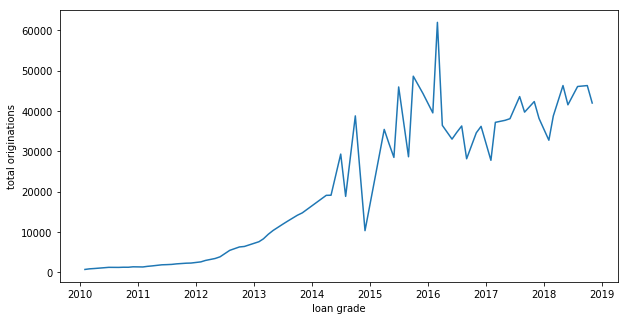

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = plt.plot(df[['orig_month']].groupby(df['orig_month']).count())
_ = plt.xlabel('origination date')
_ = num_grades = df['grade'].value_counts().sort_index()
_ = plt.xlabel('loan grade')
_ = plt.ylabel('total originations')

plt.show()

## Originations by Grade

Lending Club loans are broken out into letter grades based on the credit characteristics of the borrower, with A-grade loans belonging to the most creditworthy borrowers and G-grade loans the least creditworthy borrowers. The graph below shows total originations by grade for all loans. There are fewer grade A loans than grade B loans, but from grades B through G there are fewer loans for each grade than for the one before.

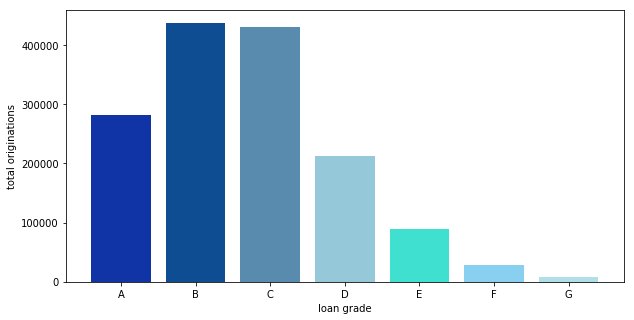

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
num_grades = df['grade'].value_counts().sort_index()
_ = plt.bar(num_grades.index, num_grades.values, color=['#1034A6', '#0E4D92', '#588BAE', '#95C8D8', '#3FE0D0', '#89CFF0', '#B0DFE5'])
_ = plt.xlabel('loan grade')
_ = plt.ylabel('total originations')
plt.show()

## Average Loan Sizes Over Time
The average loan size started out quite small in 2010 and 2011, but since around late 2012 has consistently been between just under \\$14,000 and just over \\$16,000.

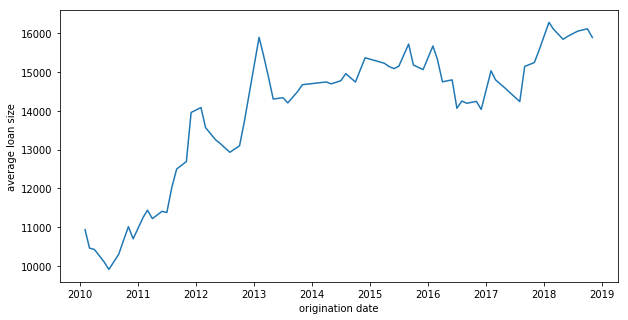

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = plt.plot(df[['orig_month', 'loan_amnt']].groupby(df['orig_month']).mean())
_ = plt.xlabel('origination date')
_ = plt.ylabel('average loan size')

plt.show()

This project focuses on potential predictors of charge-offs that change over time, so the likelihood of default by month is the outcome variable of interest. The following code subsets loans to those that have completed their term, then groups by origination month, term, and grade, which are expected to influence charge-off rates.

Additionally, the macroeconomic variables that are going to be compared to are included as columns - the unemployment rate, the number of monthly bankruptcies, and the monthly change in the S&P 500.

In [10]:
columns = ['orig_month', 'term', 'grade', 'unemployment_rate', 'monthly_bks', 'sp_500_diff']

g = df[df['loan_ended_flag']].groupby(columns)['charge_off_flag'].mean().reset_index()

As expected, default rates seem to increase significantly for higher-risk grades, as shown in the first 5 rows of the data below. The "charge_off_flag" column represents the percent of loans that charged off.

In [11]:
g.head()

,orig_month,term,grade,unemployment_rate,monthly_bks,sp_500_diff,charge_off_flag
0,2010-02-01,36 months,A,9.8,117990,25.91,0.029412
1,2010-02-01,36 months,B,9.8,117990,25.91,0.066390
2,2010-02-01,36 months,C,9.8,117990,25.91,0.170588
3,2010-02-01,36 months,D,9.8,117990,25.91,0.173469
4,2010-02-01,36 months,E,9.8,117990,25.91,0.208333


The following shows default rates over time for 36-month notes for grades A, B, and C. As expected, charge-off rates for higher grades show higher default rates. There are grades A through G, but evaluating grades A through C clearly demonstrates the expected relationship.
        
Charge-off rates seem to have peaked for each loan grade in the final quarter of 2011 or beginning of 2012. They then declined, bottoming out in mid-2013, and have since increased steadily.

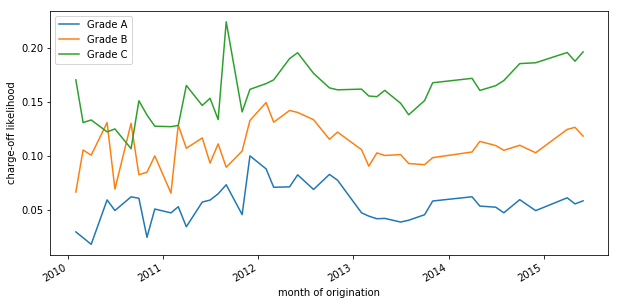

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.gca()
g.loc[(g['term'] == '36 months') & (g['grade'] == 'A')].plot(x='orig_month', y='charge_off_flag', ax=ax)
g.loc[(g['term'] == '36 months') & (g['grade'] == 'B')].plot(x='orig_month', y='charge_off_flag', ax=ax)
g.loc[(g['term'] == '36 months') & (g['grade'] == 'C')].plot(x='orig_month', y='charge_off_flag', ax=ax)
ax.legend(['Grade A', 'Grade B', 'Grade C'])
_ = plt.xlabel('month of origination')
_ = plt.ylabel('charge-off likelihood')

# Macroeconomic Factors

The focus of this project is to determine whether macroeconomic factors, such as the unemployment rate, the number of monthly bankruptcy filings, or stock market changes around the time of origination have an impact on charge-off risk. First, each of the three indicated potential factors will be visualized over time.

In [13]:
bk_monthly = g.groupby('orig_month')['monthly_bks'].mean()
unemployment_monthly = g.groupby('orig_month')['unemployment_rate'].mean()
sp_monthly = g.groupby('orig_month')['sp_500_diff'].mean()

### Bankruptcies Over Time
Overall, bankruptcies have declined from 2010 to 2015, which is expected as the economy was improving during this period. There is clear seasonality - rates are highest at the beginning of each year.

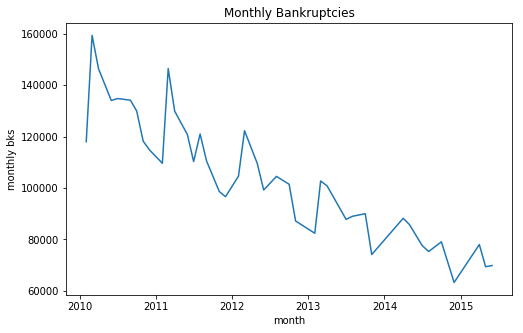

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = plt.plot(bk_monthly)
_ = plt.xlabel('month')
_ = plt.ylabel('monthly bks')
_ = plt.title('Monthly Bankruptcies')
plt.show()

### Unemployment Over Time
The unemployment rate similarly decreased over nearly the entire period that is analyzed. Unlike bankruptcies, seasonality is not present; this is to be expected, as the monthly unemployment rate from the FRED data source is seasonally adjusted.

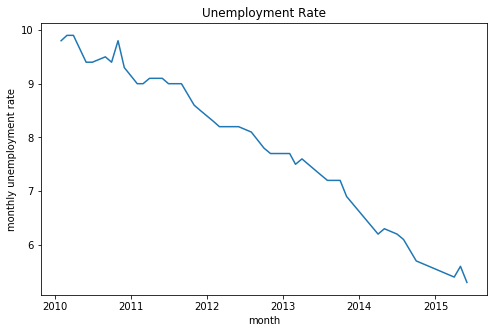

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = plt.plot(unemployment_monthly)
_ = plt.xlabel('month')
_ = plt.ylabel('monthly unemployment rate')
_ = plt.title('Unemployment Rate')
plt.show()

### S&P 500 Over Time
The below shows each month's beginning-of-month to end-of-month <i>change</i> in the S&P 500. This variable is used as it is expected that <i>changes</i> in stock indices would predict individuals' financial well-being better than the absolute value of stock indices.

The change is extremely volatile, showing no clear seasonal trends or trends over time. This appears to be consistent with the "random walk hypothesis," that change in stock values is essentially random.

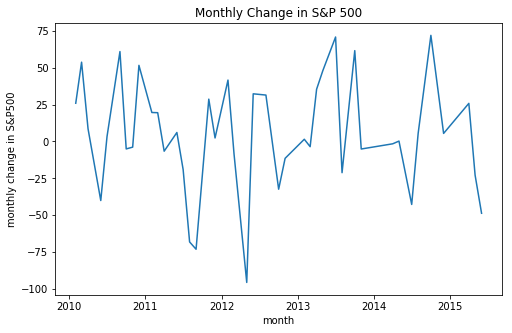

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = plt.plot(sp_monthly)
_ = plt.xlabel('month')
_ = plt.ylabel('monthly change in S&P500')
_ = plt.title('Monthly Change in S&P 500')
plt.show()

## Relationship Between Macroeconomic Factors and Charge-Off Rates

The outcome variable of interest is the likelihood that a loan will charge off. The three macroeconomic factors described above will be compared to the observed default rates each month to see if there appears to be a relationship between any of the macroeconomic factors and charge-off rates.

To compare across loan "grades" would risk creating spurious correlations, as the composition of loan grades may change over time. As a result, these will be shown for A- and D-grade loans for each variable (for a rough comparison of low- and high-risk loans, respectively), and for 36- and 60-month terms separately.

### Bankruptcies

The graphs below show the relationship between the monthly bankruptcy rates (x-axis) and the proportion of loans originated during that month that were charged off (y-axis), for each month where there is data.

The hypothesized positive relationship between monthly bankruptcies and the charge-off rate does not clearly present from the data; if anything, there seems to be a negative relationship between the variables of interest for some of the specifications.

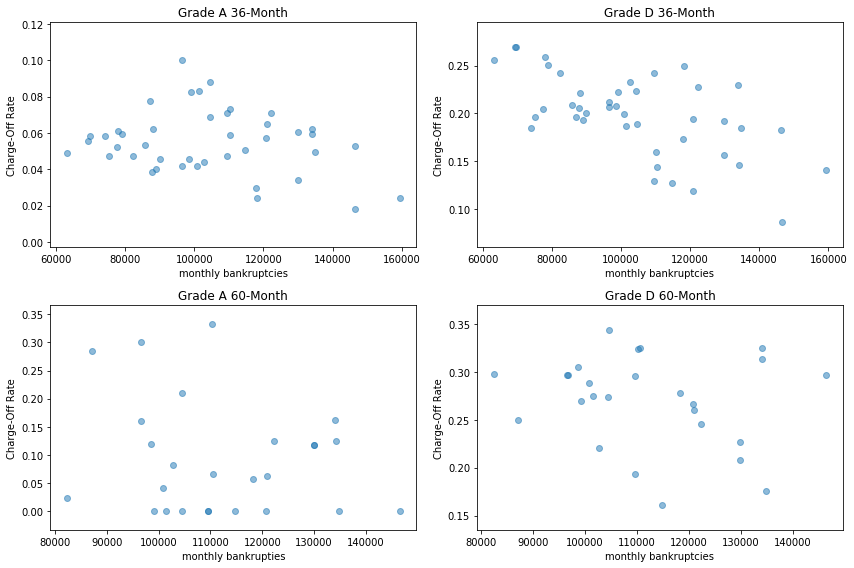

In [17]:
# Set the index for the grouped dataset, g, to the date column to facilitate graphing
grouped_months = g.set_index('orig_month')

# Subset the data to only the term, grade, bankruptcies during the month, and charge off rate
bk_subset = grouped_months[['term', 'grade', 'monthly_bks', 'charge_off_flag']]

# Subset for each of the four term-grade combinations; 36 months, 60 months, grade A, and grade D
a_36 = bk_subset.loc[(bk_subset.term=='36 months') & (bk_subset.grade == 'A')]
d_36 = bk_subset.loc[(bk_subset.term=='36 months') & (bk_subset.grade == 'D')]
a_60 = bk_subset.loc[(bk_subset.term=='60 months') & (bk_subset.grade == 'A')]
d_60 = bk_subset.loc[(bk_subset.term=='60 months') & (bk_subset.grade == 'D')]

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(2, 2, 1)
_ = plt.scatter(a_36['monthly_bks'], a_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 36-Month')
_ = plt.xlabel('monthly bankruptcies')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 2)
_ = plt.scatter(d_36['monthly_bks'], d_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 36-Month')
_ = plt.xlabel('monthly bankruptcies')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 3)
_ = plt.scatter(a_60['monthly_bks'], a_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 60-Month')
_ = plt.xlabel('monthly bankrupties')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 4)
_ = plt.scatter(d_60['monthly_bks'], d_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 60-Month')
_ = plt.xlabel('monthly bankruptcies')
_ = plt.ylabel('Charge-Off Rate')

plt.tight_layout()
plt.show()

### Unemployment Rate

The graphs below show the relationship between the monthly unemployment rate (x-axis) and the proportion of loans originated during that month that were charged off (y-axis), for each month where there is data.

The hypothesized positive relationship between the unemployment rate and the charge-off rate does not seem to be present, especially for loans with 36-month terms.

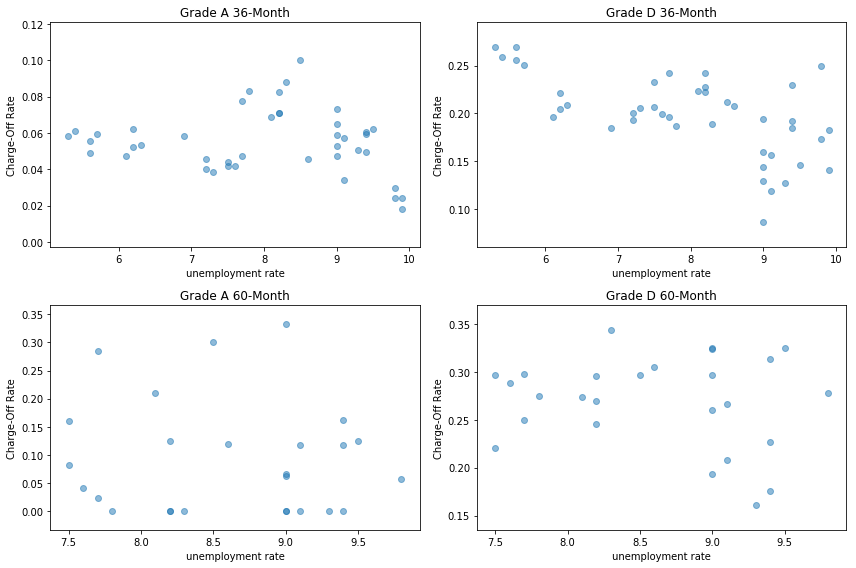

In [18]:
# Set the index for the grouped dataset, g, to the date column to facilitate graphing
grouped_months = g.set_index('orig_month')

# Subset the data to only the term, grade, S&P 500 difference, and charge off rate
un_subset = grouped_months[['term', 'grade', 'unemployment_rate', 'charge_off_flag']]

# Subset for each of the four term-grade combinations; 36 months, 60 months, grade A, and grade D
a_36 = un_subset.loc[(un_subset.term=='36 months') & (un_subset.grade == 'A')]
d_36 = un_subset.loc[(un_subset.term=='36 months') & (un_subset.grade == 'D')]
a_60 = un_subset.loc[(un_subset.term=='60 months') & (un_subset.grade == 'A')]
d_60 = un_subset.loc[(un_subset.term=='60 months') & (un_subset.grade == 'D')]

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(2, 2, 1)
_ = plt.scatter(a_36['unemployment_rate'], a_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 36-Month')
_ = plt.xlabel('unemployment rate')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 2)
_ = plt.scatter(d_36['unemployment_rate'], d_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 36-Month')
_ = plt.xlabel('unemployment rate')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 3)
_ = plt.scatter(a_60['unemployment_rate'], a_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 60-Month')
_ = plt.xlabel('unemployment rate')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 4)
_ = plt.scatter(d_60['unemployment_rate'], d_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 60-Month')
_ = plt.xlabel('unemployment rate')
_ = plt.ylabel('Charge-Off Rate')

plt.tight_layout()
plt.show()

### S&P 500

The graphs below show the relationship between the monthly change in the S&P 500 (x-axis) and the proportion of loans originated during that month that were charged off (y-axis), for each month where there is data.

The hypothesized negative relationship between changes in the S&P 500 and the charge-off rate does not clearly present from the data.

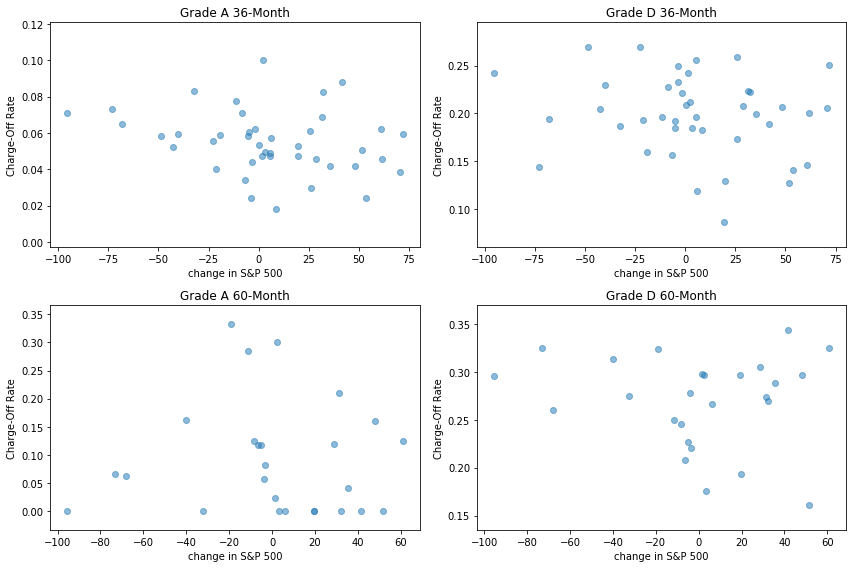

In [19]:
# Set the index for the grouped dataset, g, to the date column to facilitate graphing
grouped_months = g.set_index('orig_month')

# Subset the data to only the term, grade, S&P 500 difference, and charge off rate
sp_subset = grouped_months[['term', 'grade', 'sp_500_diff', 'charge_off_flag']]

# Subset for each of the four term-grade combinations; 36 months, 60 months, grade A, and grade D
a_36 = sp_subset.loc[(sp_subset.term=='36 months') & (sp_subset.grade == 'A')]
d_36 = sp_subset.loc[(sp_subset.term=='36 months') & (sp_subset.grade == 'D')]
a_60 = sp_subset.loc[(sp_subset.term=='60 months') & (sp_subset.grade == 'A')]
d_60 = sp_subset.loc[(sp_subset.term=='60 months') & (sp_subset.grade == 'D')]

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(2, 2, 1)
_ = plt.scatter(a_36['sp_500_diff'], a_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 36-Month')
_ = plt.xlabel('change in S&P 500')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 2)
_ = plt.scatter(d_36['sp_500_diff'], d_36['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 36-Month')
_ = plt.xlabel('change in S&P 500')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 3)
_ = plt.scatter(a_60['sp_500_diff'], a_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade A 60-Month')
_ = plt.xlabel('change in S&P 500')
_ = plt.ylabel('Charge-Off Rate')

plt.subplot(2, 2, 4)
_ = plt.scatter(d_60['sp_500_diff'], d_60['charge_off_flag'], alpha=.5)
_ = plt.title('Grade D 60-Month')
_ = plt.xlabel('change in S&P 500')
_ = plt.ylabel('Charge-Off Rate')

plt.tight_layout()
plt.show()

# Conclusions

Initial data exploration does not reveal obvious strong relationships between any of the macroeconomic variables analyzed and default rates. There may be relationships that are discoverable through further statistical testing, which will be explored in future projects.

In [20]:
c = columns + ['charge_off_flag']
df.loc[df['loan_ended_flag']][c].to_pickle('stat_data.pkl')